## 15-14. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

### 루브릭

|평가문항|	상세기준|
|:---|:---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

### Step 1. 데이터 수집 및 분석
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

>wget으로 데이터 다운로드
><br>$ wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv</br>

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from konlpy.tag import Hannanum, Kkma, Komoran, Okt, Twitter # 힌글 자연어 처리기

In [317]:
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv

--2021-03-07 19:48:16--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 52.78.231.108
접속 github.com (github.com)|52.78.231.108|:443... 접속됨.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-03-07 19:48:17--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv.3’

ChatbotData .csv.3  100%[===================>] 868.99K  4.53MB/s    in 0.2s    

2021-03-07 19:48:17 (4.53 MB/s) - ‘ChatbotData .csv.3’ saved [889842/889842]



In [318]:
data = pd.read_csv('ChatbotData .csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [319]:
# 질문과 답변을 하나의 리스트로 만들어서 길이 및 분포, 빈도수 등을 분석해보자.
sentences = list(data['Q']) + list(data['A'])

In [320]:
#분석을 위한 토크나이즈

token_sentences = [s.split() for s in sentences]
sent_len_by_token = [len(t) for t in token_sentences]
sent_len_by_syllable = [len(s.replace(' ', '')) for s in sentences]

okt = Okt()

morph_token_sentences = [okt.morphs(s.replace(' ', '')) for s in sentences]
sent_len_by_morph = [len(t) for t in morph_token_sentences]

Text(0, 0.5, 'Number of sentence')

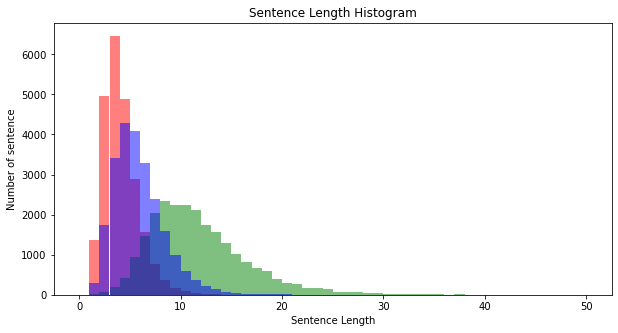

In [321]:
plt.figure(figsize = (10, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color='r', label = 'syllable')
plt.hist(sent_len_by_syllable, bins=50, range=[0,50], alpha=0.5, color='g', label = 'syllable')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='b', label = 'syllable')

plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of sentence')

* 빨간색 = 어절단위의 토크나이즈 결과
* 초록색 = 형태소
* 파란색 = 음절단위(가장 긴 길이)
위 히스토그램으로는 분초나, 이상치 등을 파악하기 어려움으로 y값의 분포르 ㄹ조정한 후 다시 확인해 보자.

Text(0, 0.5, 'Number of sentence')

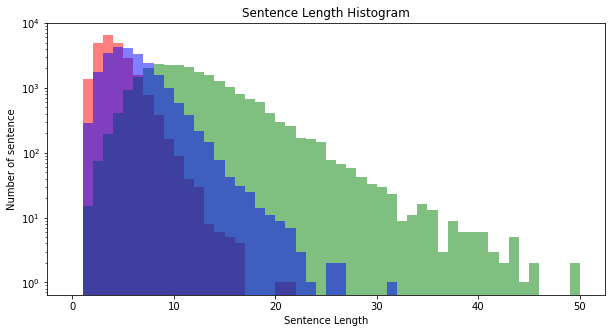

In [322]:
# 데이터 길이에 대한 히스토그램 + 로그변환
plt.figure(figsize = (10, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color='r', label = 'syllable')
plt.hist(sent_len_by_syllable, bins=50, range=[0,50], alpha=0.5, color='g', label = 'syllable')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='b', label = 'syllable')
plt.yscale('log')
plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of sentence')

* 어절의 경우 20에서 이상치 발생
* 음절의 경우 45이상 50전에서 이상치 발생
* 형태소의 경우 30 이상에서 이상치가 발생하는 것으로 파악 됨. 

이러한 길이 분포의 분석한 내용을 바탕으로 입력문장의 길이를 어떻게 설정할 지 결정한다. 

길이분포에 대한 통계치를 보다 정확하게 분석하기위해 길이에 대한 여러가지 통계값을 확인해 보도록 하자. (Numpy이용)

In [323]:
print('어절 최대 길이: {}'.format(np.max(sent_len_by_token)))
print('어절 최소 길이: {}'.format(np.min(sent_len_by_token)))
print('어절 평균 길이: {:.2f}'.format(np.mean(sent_len_by_token)))
print('어절 표준편차 길이: {:.2f}'.format(np.std(sent_len_by_token)))
print('어절 중간값 길이: {:.2f}'.format(np.median(sent_len_by_token)))

어절 최대 길이: 21
어절 최소 길이: 1
어절 평균 길이: 3.64
어절 표준편차 길이: 1.74
어절 중간값 길이: 3.00


In [324]:
def df_maker(col_num, ind_num, fill):
    col = []
    ind = []
    con = []
    for i in range(0,col_num):
        col.append(fill)
    for i in range(0,ind_num):
        ind.append(fill)
    for i in range(0,ind_num):
        con.append(col)
    return pd.DataFrame(con, columns=col, index=ind)

In [325]:
lenth_values = df_maker(5,3,0)
col = ['max', 'min', 'mean', 'std', 'median']
ind = ['어절', '음절', '형태소']
lenth_values.columns = col
lenth_values.index = ind

print(lenth_values)

     max  min  mean  std  median
어절     0    0     0    0       0
음절     0    0     0    0       0
형태소    0    0     0    0       0


In [326]:
lenth_values['max'] =[ np.max(sent_len_by_token),np.max(sent_len_by_syllable), np.max(sent_len_by_morph) ]
lenth_values['min'] =[ np.min(sent_len_by_token),np.min(sent_len_by_syllable), np.min(sent_len_by_morph) ]
lenth_values['mean'] =[ np.mean(sent_len_by_token), np.mean(sent_len_by_syllable), np.mean(sent_len_by_morph) ]
lenth_values['std'] =[ np.std(sent_len_by_token),np.std(sent_len_by_syllable), np.std(sent_len_by_morph) ]
lenth_values['median'] =[ np.median(sent_len_by_token),np.median(sent_len_by_syllable), np.median(sent_len_by_morph) ]

In [327]:
print(lenth_values)

     max  min       mean       std  median
어절    21    1   3.640531  1.742913     3.0
음절    57    1  11.306563  4.978838    10.0
형태소   31    1   5.412543  2.560910     5.0


<function boxplot at 0x7f1b087ba320>


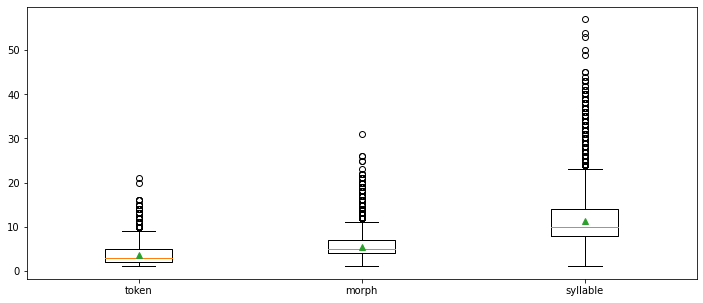

In [328]:
# box plot으로 확인

plt.figure(figsize=(12,5))
plt.boxplot([sent_len_by_token, sent_len_by_morph,sent_len_by_syllable,  ],
           labels = ['token', 'morph', 'syllable'],
            showmeans=True)

print(plt.boxplot)

이렇게 살펴본 데이터는 질문과 답변을 분리하여 다시 살펴볼 수 있다. 두개를 합하여 리스트로 만들어 살펴본 결과 이상치와 음절, 형태소, 어절 단위로 분포를 살펴볼 수 있었다. 
음절의 경우 가장 길이 분포가 가장 크크모 max_length를 결정할 때, 고려하도록 한다. 
LMS에서는 전체 길이를 40으로 하였으나, 대략 30정도가 적당해 보인다. 실제로 40으로 하여, 1차 학습을 진행하였을 때와 데이터 분석 후 길이를 수정하였을 때, 결과값을 비교해 보고자 한다. 

### 데이터 어휘 빈도 분석
text데이터를 분석함에 있어서, 길이뿐 아니라 어휘의 빈도를 분석하는 방법도 있다. 이 떼, 품사분석기를 사용하여 조사가 아닌 의미상 중요한 명서, 동사, 형용사 등만 따로 모은 후 분석이 가능하다. 앞서 길이 분석에 사용한 KoNLPy의 품사분류 모듈을 사용한다. (Okt의 품사분류기능)


In [329]:
okt.pos('아침 기온이 유난히 쌀쌀하다')

[('아침', 'Noun'),
 ('기온', 'Noun'),
 ('이', 'Josa'),
 ('유난히', 'Adverb'),
 ('쌀쌀하다', 'Adjective')]

문장안의 단어를 품사별로 나눠주는 것을 확인 할 수 있다. 명사, 동사, 형용사만 필요하니, 이를 제외한 나버지 품사들은 제거한 문자열 리스트를 만든다. 질문과 답변을 분리하여 빈도수를 확인해보자.

In [330]:
question_sentences = list(data['Q'])
answer_sentences = list(data['A'])

In [331]:
question_pos_sentences = list()
answer_pos_sentsnces = list()

for s in question_sentences:
    for token, tag in okt.pos(s.replace(' ', '')):
        if tag =='None' or tag == 'Verb' or tag == 'Adjective':
            question_pos_sentences.append(token)
            
for s in answer_sentences:
    for token, tag in okt.pos(s.replace(' ', '')):
        if tag =='None' or tag == 'Verb' or tag == 'Adjective':
            answer_pos_sentsnces.append(token)   
            
question_pos_sentences = ' '.join(question_pos_sentences)
answer_pos_sentsnces = ' '.join(answer_pos_sentsnces)

In [332]:
print(len(question_pos_sentences))

68833


In [333]:
question_wordcloud = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='black').generate(question_pos_sentences)


<function matplotlib.pyplot.show(close=None, block=None)>

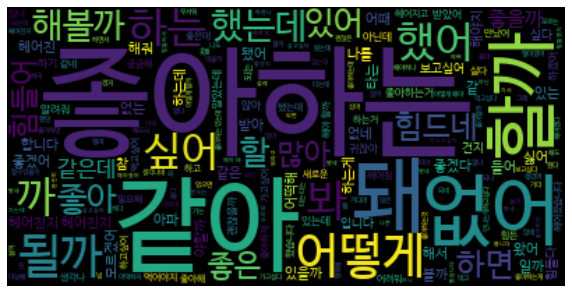

In [334]:
plt.figure(figsize=(10,10))
plt.imshow(question_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [335]:
answer_wordcloud = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='black').generate(answer_pos_sentsnces)


<function matplotlib.pyplot.show(close=None, block=None)>

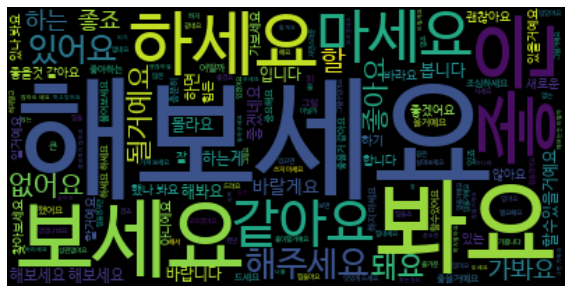

In [336]:
plt.figure(figsize=(10,10))
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

### Step 2. 데이터 전처리하기
---
null 값은 별도로 존재하지 않습니다. 원 데이터에서 ?, ., !와 같은 구두점을 미리 처리해두어야 하는데, 구두점들을 단순히 제거할 수도 있겠지만, 여기서는 구두점 앞에 공백. 즉, 띄어쓰기를 추가하여 다른 문자들과 구분하겠습니다. 

전처리는 질문 데이터와 답변 데이터 모두에 적용해줍니다.

In [337]:
print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [338]:
questions = []
for sentence in data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([~'\"?.!,:;])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [339]:
answers = []
for sentence in data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([~'\"?.!,:;])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [340]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


질문과 대답에 대해서 상위 5개만 출력하여 구두점들이 띄어쓰기를 통해 분리되었는지 확인해봅시다.
'하루가 또 가네요 .'와 같이 구두점 앞에 띄어쓰기가 추가되어 분리된 것을 확인할 수 있습니다.

### Step 3. SubwordTextEncoder 사용하기
---
질문과 답변의 셋을 각각 questions와 answers에 저장하였으므로, 앞서 데이터 분석을 하기위해 형태소 분석기(Okt)를 사용했지만, 이 후로는  LMS에 나온 텐서플로우 내부 단어 토크나이저인 SubwordTextEncoder를 사용해서 본격적인 데이터 전처리를 수행한다. 

#### 3-1. 토크나이져

In [341]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

디코더의 입력으로 사용할 시작을 의미하는 시작 토큰 SOS와 종료 토큰 EOS 또한 존재합니다. 해당 토큰들도 단어 집합에 포함시킬 필요가 있으므로 이 두 토큰에 정수를 부여해줍니다.

In [342]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [343]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8182]
종료 토큰 번호 : [8183]
단어 집합의 크기 : 8184


In [344]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5767, 611, 3509, 141, 685, 3747, 849]


In [345]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


#### 3-2.정수 인코딩과 패딩

In [346]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [347]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8184
필터링 후의 샘플 개수: 11823
필터링 후의 샘플 개수: 11823


In [348]:
#정수 인코딩과 패딩이 진행된 후의 데이터의 크기를 확인

# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8182 7918 4207 3060   41 8183    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8182 3844   74 7896    1 8183    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### dataset 만들기
tf.data.Dataset을 사용하여 데이터를 배치 단위로 불러올 수 있습니다.

In [349]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [350]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8182 3844   74 7896    1 8183    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8182 3844   74 7896    1 8183    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7896    1 8183    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

**주요 하이퍼파라미터의 값**
* dmodel = 256
* num_layers = 2
* num_heads = 8
* dff = 512 

In [351]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [363]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output #context_vector(문맥벡터))

In [364]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
#d_model는 어텐션 연산을 할 때, K,Q,V에 대한 차원을 정의하기 위한 파라미터 이므로, 헤드의 개수만큼 나눠져야 하기 때문에 d_model와num_heads를 나눴을 때, 나머지가 발생해서는 안된다. 
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷-프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [365]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [366]:
#forword masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [367]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전연결층 (포지션 와이즈 피드 포워드 네트웍)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [368]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [369]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [370]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [371]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

      # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [372]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 512)    13658112    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실함수

In [373]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 커스텀 학습률

In [374]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [375]:
#학습률과 옵티마이저를 정의하고 모델을 컴파일합니다.

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [401]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=10, 
                                                     restore_best_weights=True)
EPOCHS = 50

In [402]:
with tf.device('/GPU:0'):
    history = model.fit(
        dataset, 
        epochs=EPOCHS,
        callbacks=[ early_stopping_cb]

)

Epoch 1/50
185/185 [==============================] - 35s 189ms/step - loss: 0.0172 - accuracy: 0.1705
Epoch 2/50
185/185 [==============================] - 35s 190ms/step - loss: 0.0176 - accuracy: 0.1704
Epoch 3/50
185/185 [==============================] - 36s 192ms/step - loss: 0.0159 - accuracy: 0.1709
Epoch 4/50
185/185 [==============================] - 36s 194ms/step - loss: 0.0155 - accuracy: 0.1710
Epoch 5/50
185/185 [==============================] - 36s 195ms/step - loss: 0.0152 - accuracy: 0.1710
Epoch 6/50
185/185 [==============================] - 36s 193ms/step - loss: 0.0150 - accuracy: 0.1712
Epoch 7/50
185/185 [==============================] - 36s 193ms/step - loss: 0.0149 - accuracy: 0.1711
Epoch 8/50
185/185 [==============================] - 36s 196ms/step - loss: 0.0137 - accuracy: 0.1714
Epoch 9/50
185/185 [==============================] - 36s 193ms/step - loss: 0.0140 - accuracy: 0.1714
Epoch 10/50
185/185 [==============================] - 36s 193ms/step - l


### Step 5. 모델 평가하기
---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

### 학습 종료 후 모델 성능 시각화

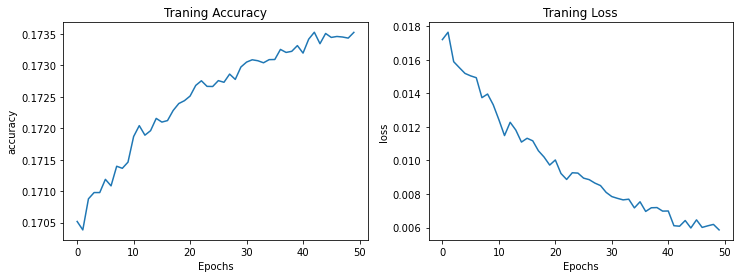

In [407]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Traning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'])


plt.subplot(122)
plt.title('Traning Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'])
plt.show()

In [408]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [409]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [410]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

#### 150 번 epochs결과

In [411]:
output = predict("남자친구 생일 선물로 뭐가 좋을까?")

Input: 남자친구 생일 선물로 뭐가 좋을까?
Output: 그건 따라 다르지 않을까요 .


In [419]:
output = predict("날 알아주는 친구를 만나고 싶어")

Input: 날 알아주는 친구를 만나고 싶어
Output: 현실적인 문제가 중요할 때가 있죠 .


In [413]:
output = predict("나랑 여행 갈래?")

Input: 나랑 여행 갈래?
Output: 같이 좋을 것 같아요 .


In [418]:
output = predict("인생은 뭐라고 생각해?")

Input: 인생은 뭐라고 생각해?
Output: 당장 비행기표 예약하세요 .


In [415]:
output = predict("나도 휴가가 있었으면 좋겠다.")

Input: 나도 휴가가 있었으면 좋겠다.
Output: 휴가가 간절하겠네요 .


#### 50번 epochs 결과

![스크린샷, 2021-03-07 16-10-18](https://user-images.githubusercontent.com/76939885/110240123-bfce0b80-7f8d-11eb-9f61-2c895ac30c5e.png)

## 총평

* 학습을 많이 할 수록 더 나은 성과를 얻을 수 있었다. 
* 그동안 배운 데이터 분석 기법을 추가로 사용해 보았다. 
* 마지막 질문에 대한 답변을 보아서, 한국어 학습도 그럴듯하게 진행된 것 같다. (1차 시도했던 답변과 비교)
* 이전에 배운 어텐션을 이용한 seq2seq 모델로 학습해서 비교해 보는 것도 밀린 노드를 끝내면, 진행 해 보고자 한다. 해보고 싶은(아쉬움이 남는) 과제가 남아서 기대가되는 노드 였던 것 같다. 